In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

from scipy.stats import entropy
import pandas as pd
import numpy as np
import onnxruntime as rt

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# constants and parameters definition

data_path = '../data/300k_dataset.csv'
model1_path = '../Group 9/model_1.onnx'
model2_path = '../Group 9/model_2.onnx'

In [1]:
import pandas as pd
import numpy as np
import onnxruntime as rt
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns

def equivalence_testing_with_bins(
        model_path, data_address, sensitive_attributes, bins=5
):
    
    data = pd.read_csv(data_address)
    X = data.drop(['checked', 'Ja', 'Nee'], axis=1).astype(np.float32)

    session = rt.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name

    results = {}

    for attr in sensitive_attributes:
        print(f"Testing sensitive attribute: {attr}")

        # 如果是连续属性，进行分箱
        if data[attr].dtype in [np.float64, np.int64]:
            data[f"{attr}_bins"] = pd.cut(data[attr], bins=bins)
            unique_values = data[f"{attr}_bins"].unique()
        else:
            unique_values = data[attr].unique()

        distributions = {}

        for value in unique_values:
            if pd.isnull(value):  
                continue

            if data[attr].dtype in [np.float64, np.int64]:
                mask = (data[f"{attr}_bins"] == value)
            else:
                mask = (data[attr] == value)

            sub_X = X[mask]

            preds = session.run(None, {input_name: sub_X.values})[0]
            if preds.ndim > 1:
                preds = np.argmax(preds, axis=1)

            dist = np.bincount(preds, minlength=np.max(preds) + 1) / len(preds)
            distributions[value] = dist
        metrics = []
        for i, value1 in enumerate(unique_values):
            for j, value2 in enumerate(unique_values):
                if i < j and value1 is not None and value2 is not None:
                    kl_div = entropy(distributions[value1], qk=distributions[value2])
                    metrics.append({
                        "value1": value1,
                        "value2": value2,
                        "kl_divergence": kl_div
                    })

        results[attr] = pd.DataFrame(metrics)
        print(f"Results for {attr}:\n", results[attr])

    return results

def visualize_equivalence_testing_with_bins(results):
    """
    可视化等价测试结果，使用区间的 KL 散度热力图。

    :param results: `equivalence_testing_with_bins` 返回的结果
    """
    for attr, df in results.items():
        pivot_kl = df.pivot(index="value1", columns="value2", values="kl_divergence")
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            pivot_kl, annot=True, fmt=".4f", cmap=sns.diverging_palette(250, 38.823529411765, l=65, center="dark", as_cmap=True), cbar_kws={'label': 'KL Divergence'}
        )
        plt.title(f"KL Divergences for Sensitive Attribute: {attr}")
        plt.xlabel(f"{attr} Value 2")
        plt.ylabel(f"{attr} Value 1")
        plt.tight_layout()
        plt.show()


Testing sensitive attribute: persoon_leeftijd_bij_onderzoek
Results for persoon_leeftijd_bij_onderzoek:
          value1          value2  kl_divergence
0  (57.2, 67.0]    (47.4, 57.2]       0.032890
1  (57.2, 67.0]    (27.8, 37.6]       0.355366
2  (57.2, 67.0]    (37.6, 47.4]       0.138670
3  (57.2, 67.0]  (17.951, 27.8]       0.730258
4  (47.4, 57.2]    (27.8, 37.6]       0.214717
5  (47.4, 57.2]    (37.6, 47.4]       0.048157
6  (47.4, 57.2]  (17.951, 27.8]       0.541458
7  (27.8, 37.6]    (37.6, 47.4]       0.081198
8  (27.8, 37.6]  (17.951, 27.8]       0.088791
9  (37.6, 47.4]  (17.951, 27.8]       0.304830
Testing sensitive attribute: persoon_geslacht_vrouw
Results for persoon_geslacht_vrouw:
           value1      value2  kl_divergence
0  (-0.001, 0.2]  (0.8, 1.0]        0.01711
Testing sensitive attribute: persoonlijke_eigenschappen_dagen_sinds_opvoer
Results for persoonlijke_eigenschappen_dagen_sinds_opvoer:
              value1            value2  kl_divergence
0   (-2.377, 

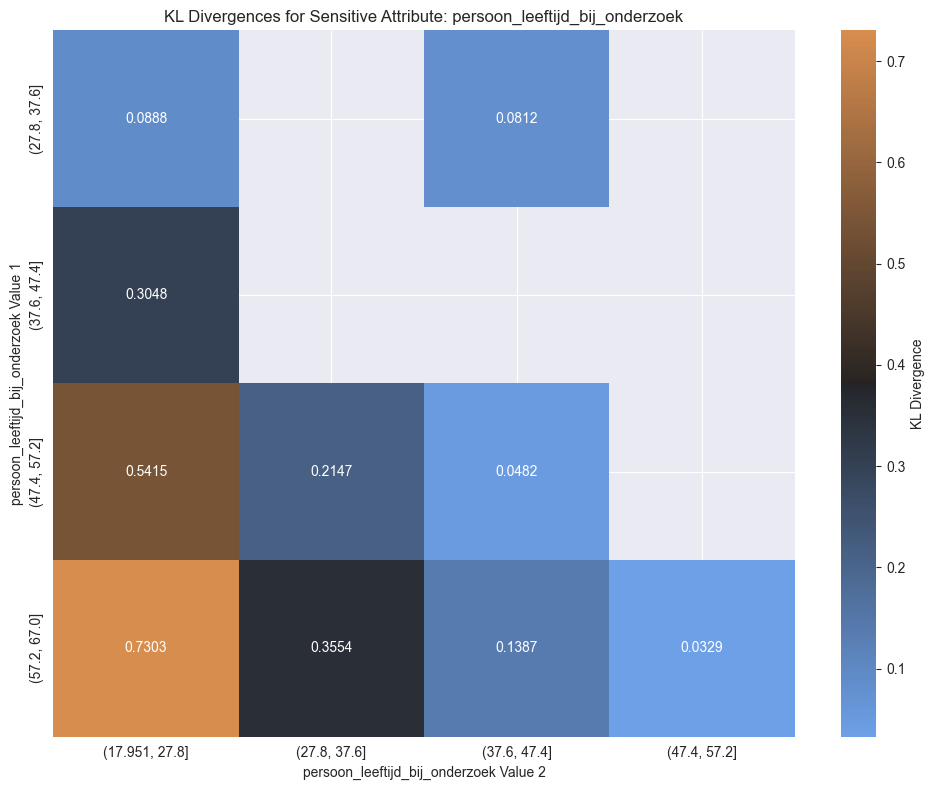

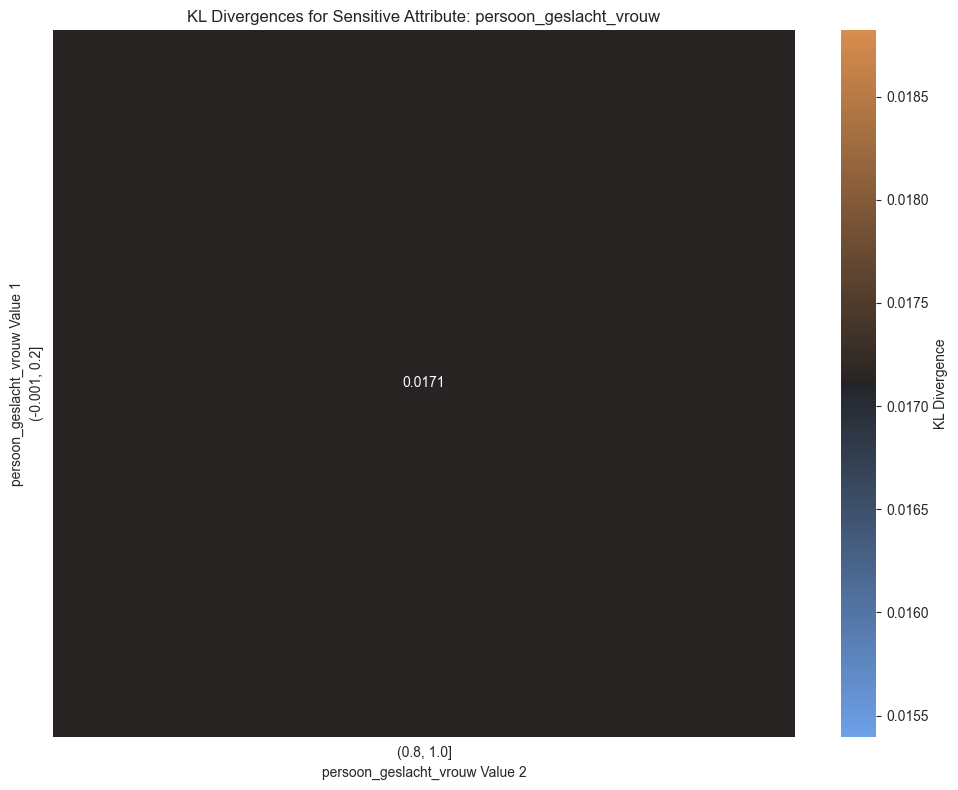

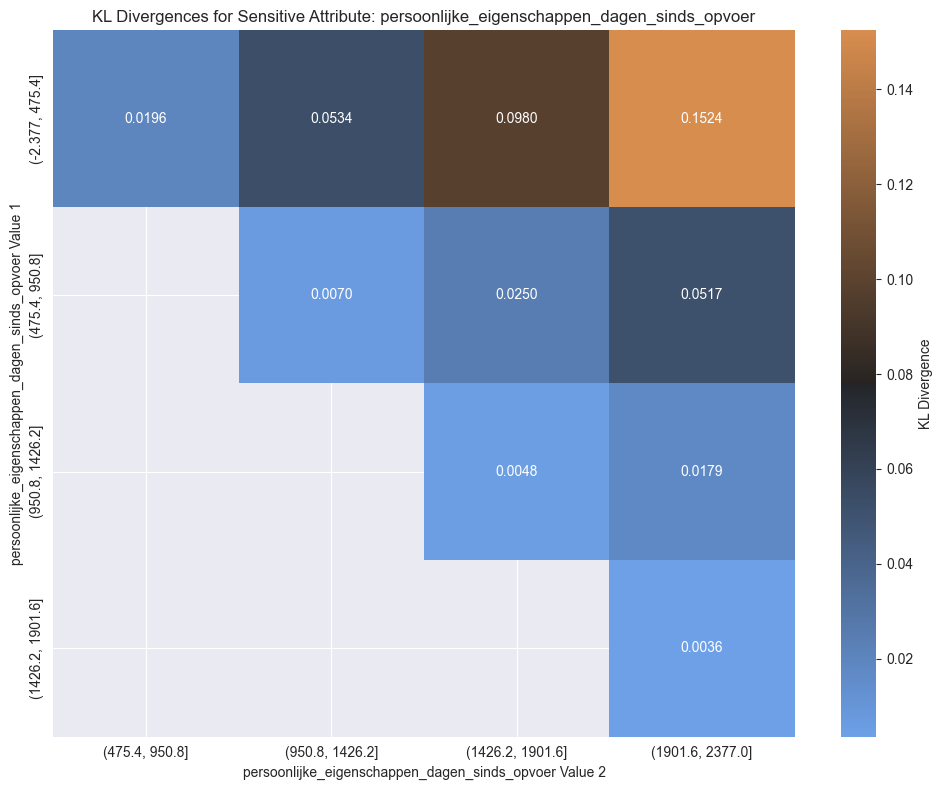

In [8]:
results = equivalence_testing_with_bins(model2_path, data_path, ["persoon_leeftijd_bij_onderzoek", "persoon_geslacht_vrouw", "persoonlijke_eigenschappen_dagen_sinds_opvoer"], bins=5)
visualize_equivalence_testing_with_bins(results)


In [5]:
# functions definition

def equivalence_testing_with_kl(model_path, data_address, sensitive_attributes):

    data = pd.read_csv(data_address)
    X = data.drop(['checked', 'Ja', 'Nee'], axis=1)
    sensitive_data = data[sensitive_attributes]
    X = X.astype(np.float32)


    session = rt.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name

    kl_results = {}

    for attr in sensitive_attributes:
        print(f"Testing KL divergence for attribute: {attr}")

        unique_values = sensitive_data[attr].unique()
        if len(unique_values) < 2:
            print(f"Attribute {attr} has less than two unique values, skipping.")
            continue

        distributions = {}
        for value in unique_values:

            mask = (sensitive_data[attr] == value)
            sub_X = X[mask]

            preds = session.run(None, {input_name: sub_X.values.astype(np.float32)})[0]
            if preds.ndim > 1:
                preds = np.argmax(preds, axis=1)

            dist = np.bincount(preds, minlength=np.max(preds) + 1) / len(preds)
            distributions[value] = dist

        kl_divergences = []
        for i, value1 in enumerate(unique_values):
            for j, value2 in enumerate(unique_values):
                if i < j: 
                    kl_div = entropy(distributions[value1], qk=distributions[value2])
                    kl_divergences.append({
                        "value1": value1,
                        "value2": value2,
                        "kl_divergence": kl_div
                    })

        kl_results[attr] = pd.DataFrame(kl_divergences)

        print(f"KL Divergences for {attr}:")
        print(kl_results[attr])

    return kl_results

def visualize_kl_results_heatmap(kl_results):
    """
    使用热力图可视化 KL 散度结果。
    
    :param kl_results: `equivalence_testing_with_kl` 返回的分析结果。
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    for attr, df in kl_results.items():
        # 创建数据透视表
        pivot_table = df.pivot(index="value1", columns="value2", values="kl_divergence")

        # 绘制热力图
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            pivot_table,
            annot=True,
            fmt=".4f",
            cmap="YlGnBu",
            cbar_kws={'label': 'KL Divergence'}
        )
        plt.title(f"KL Divergences for Sensitive Attribute: {attr}")
        plt.xlabel(f"{attr} Value 2")
        plt.ylabel(f"{attr} Value 1")
        plt.tight_layout()
        plt.show()

Testing KL divergence for attribute: persoon_leeftijd_bij_onderzoek
KL Divergences for persoon_leeftijd_bij_onderzoek:
      value1  value2  kl_divergence
0         62      53       0.000357
1         62      54       0.000143
2         62      50       0.000527
3         62      32       0.063402
4         62      57       0.000189
...      ...     ...            ...
1220      22      18       0.002745
1221      22      20       0.001016
1222      19      18       0.005756
1223      19      20       0.009598
1224      18      20       0.000449

[1225 rows x 3 columns]
Testing KL divergence for attribute: persoon_geslacht_vrouw
KL Divergences for persoon_geslacht_vrouw:
   value1  value2  kl_divergence
0       0       1       0.000315
Testing KL divergence for attribute: persoonlijke_eigenschappen_spreektaal
KL Divergences for persoonlijke_eigenschappen_spreektaal:
     value1  value2  kl_divergence
0        57       0       0.000002
1        57      73       0.000328
2        57      

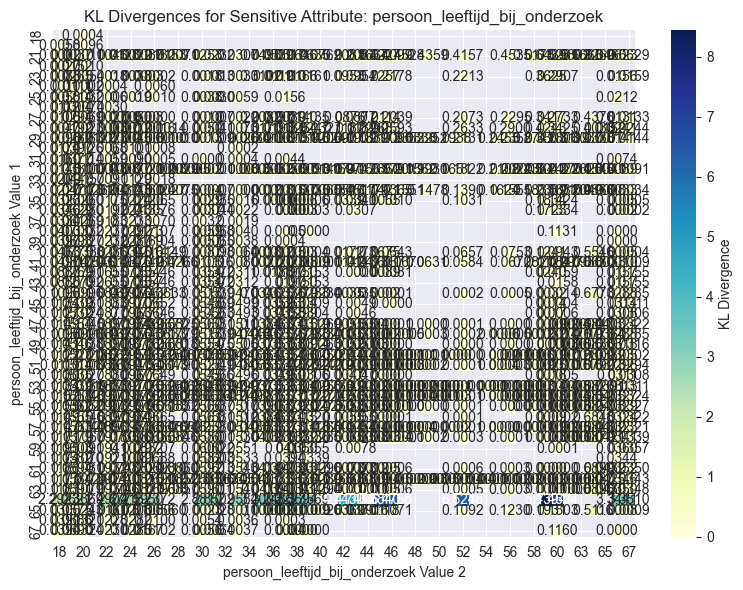

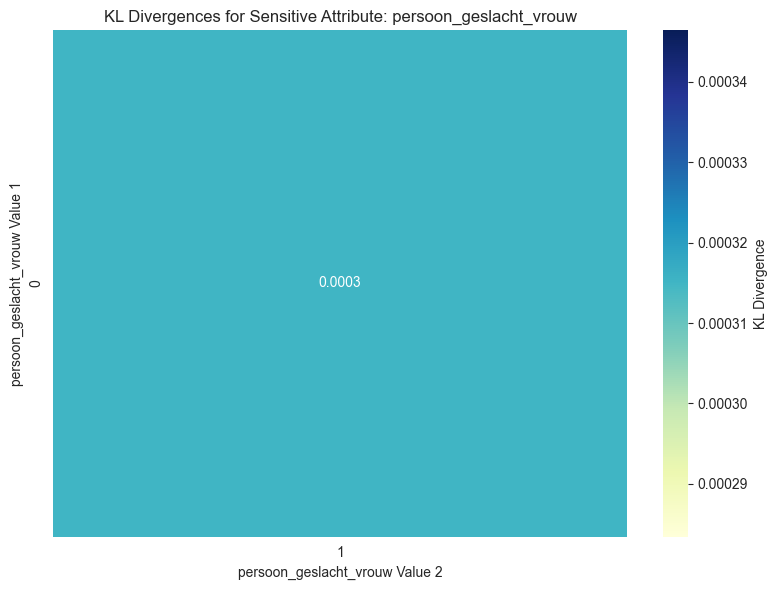

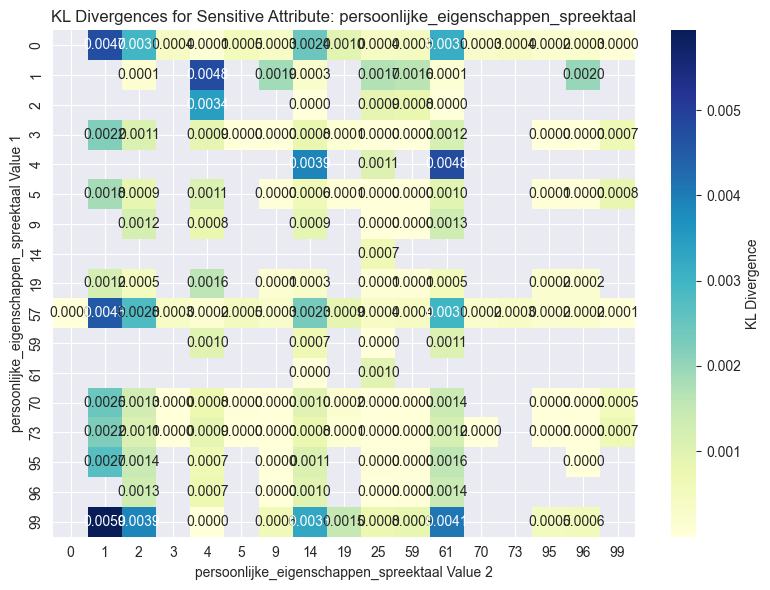

In [6]:
# test and visualize

results = equivalence_testing_with_kl(
    model1_path,
    data_path,
    sensitive_attributes = ['persoon_leeftijd_bij_onderzoek', 'persoon_geslacht_vrouw', 'persoonlijke_eigenschappen_spreektaal']
)
visualize_kl_results_heatmap(results)

Testing KL divergence for attribute: persoon_leeftijd_bij_onderzoek
KL Divergences for persoon_leeftijd_bij_onderzoek:
      value1  value2  kl_divergence
0         62      53       0.030794
1         62      54       0.025780
2         62      50       0.060810
3         62      32       0.402048
4         62      57       0.012407
...      ...     ...            ...
1220      22      18       0.005803
1221      22      20       0.000728
1222      19      18       0.002404
1223      19      20       0.022462
1224      18      20       0.010368

[1225 rows x 3 columns]
Testing KL divergence for attribute: persoon_geslacht_vrouw
KL Divergences for persoon_geslacht_vrouw:
   value1  value2  kl_divergence
0       0       1        0.01711
Testing KL divergence for attribute: persoonlijke_eigenschappen_spreektaal
KL Divergences for persoonlijke_eigenschappen_spreektaal:
     value1  value2  kl_divergence
0        57       0   1.661373e-03
1        57      73   9.794666e-08
2        57      

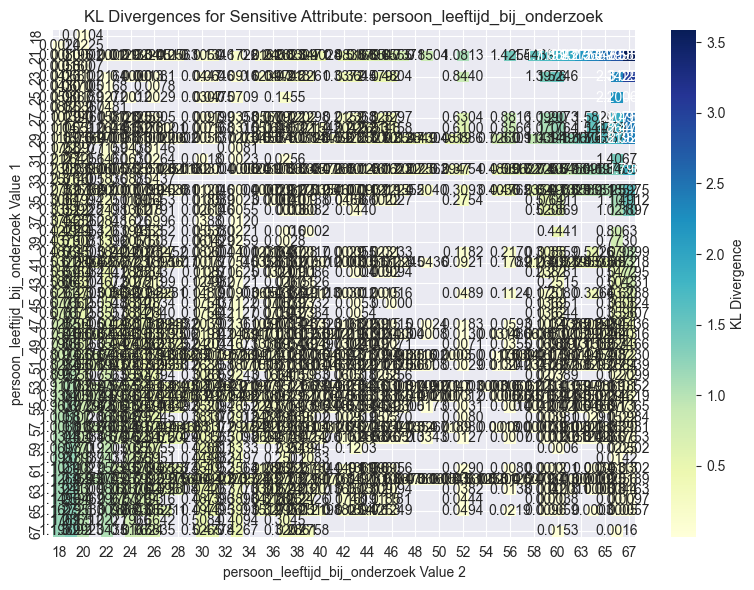

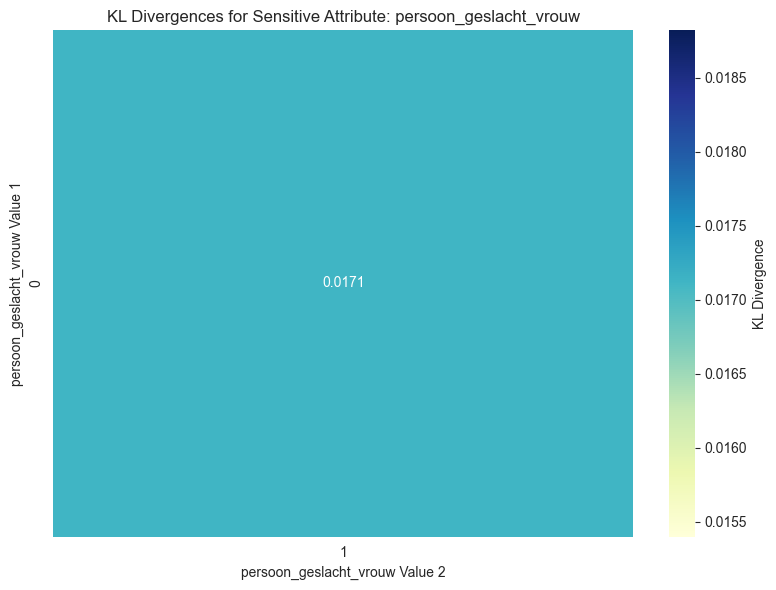

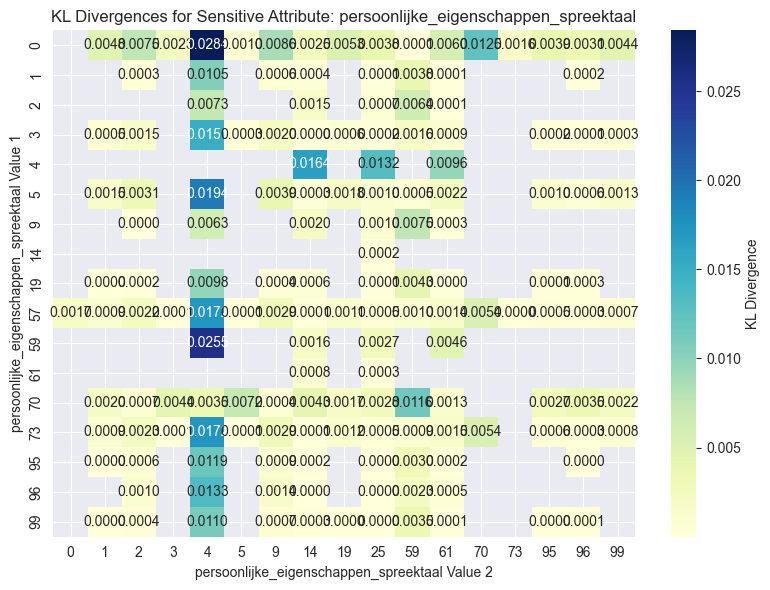

In [7]:
# test and visualize

results = equivalence_testing_with_kl(
    model2_path,
    data_path,
    sensitive_attributes = ['persoon_leeftijd_bij_onderzoek', 'persoon_geslacht_vrouw', 'persoonlijke_eigenschappen_spreektaal']
)
visualize_kl_results_heatmap(results)